## Instructions {-}

- This is the template for the code and report on the Prediction Problem assignments.

- Your code in steps 1, 3, 4, and 5 will be executed sequentially, and must produce the RMSE / accuracy claimed on Kaggle.

- Your code in step 2 will also be executed, and must produce the optimal hyperparameter values used to train the model.

In [31]:
import pandas as pd
import warnings
import seaborn as sns
import numpy as np
from datetime import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, \
cross_validate, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
import itertools as it

## Read data

In [2]:
train = pd.read_csv('./datasets/train_regression.csv')
test = pd.read_csv('./datasets/test_regression.csv')

## 1) Data pre-processing

Put the data pre-processing code. You don't need to explain it. You may use the same code from last quarter.

In [3]:
# Define a function to categorize the property types
def categorize_property(property_type):
    if 'Entire' in property_type:
        return 'Entire Home/Apartment'
    elif 'Private' in property_type:
        return 'Private Room'
    elif 'Shared' in property_type:
        return 'Shared Accommodation'
    elif property_type in ['Room in hotel', 'Room in boutique hotel', 'Boat']:
        return 'Specialty Accommodations'
    else:
        return 'Other'

In [4]:
# overall function to clean training and test data
def clean_data(df):
    
    # Remove $ from response variable and convert to float in training data
    if 'price' in df.columns:
        df.price = df.price.replace('[\$,]', '', regex=True).astype(float)
        
    # replace missing values of numeric variables wtih the median
    numeric_columns = df.select_dtypes(include=['number']).columns
    df[numeric_columns] = df[numeric_columns].apply(lambda x: x.fillna(x.median()))

    # replace missing values of categorical variables with the mode 
    categorical_columns = df.select_dtypes(include=['object']).columns
    df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])
    
    # log transform response variable for training data and drop price
    if 'price' in df.columns:
        df['log_price'] = np.log(df['price'])
    
    # replace any 0 values to 1 so that it can go through log transformation
    df['beds'] = df['beds'].replace(0, .01)
    df['accommodates'] = df['accommodates'].replace(0, .01)
    df['number_of_reviews'] = df['number_of_reviews'].replace(0, .01)
    df['reviews_per_month'] = df['reviews_per_month'].replace(0, .01)
    df['number_of_reviews_ltm'] = df['number_of_reviews_ltm'].replace(0, .01)
    df['number_of_reviews_l30d'] = df['number_of_reviews_l30d'].replace(0, .01)
    df['host_total_listings_count'] = df['host_total_listings_count'].replace(0, .01)
    df['host_listings_count'] = df['host_listings_count'].replace(0, .01)
    df['calculated_host_listings_count_private_rooms'] = df['calculated_host_listings_count_private_rooms'].replace(0, .01)
    df['calculated_host_listings_count_shared_rooms'] = df['calculated_host_listings_count_shared_rooms'].replace(0, .01)
    df['calculated_host_listings_count_entire_homes'] = df['calculated_host_listings_count_entire_homes'].replace(0, .01)
    
    df['log_beds'] = np.log(df.beds)
    df['log_accommodates'] = np.log(df.accommodates)
    df['log_reviews'] = np.log(df.number_of_reviews)
    df['log_reviews_per_month'] = np.log(df.reviews_per_month)
    df['log_reviews_ltm'] = np.log(df.number_of_reviews_ltm)
    df['log_reviews_l30d'] = np.log(df.number_of_reviews_l30d)
    df['log_host_total_listings_count'] = np.log(df.host_total_listings_count)
    df['log_host_listings_count'] = np.log(df.host_listings_count)
    df['log_host_listings_count_private_rooms'] = np.log(df.calculated_host_listings_count_private_rooms)
    df['log_host_listings_count_shared_rooms'] = np.log(df.calculated_host_listings_count_shared_rooms)
    df['log_host_listings_count_entire_homes'] = np.log(df.calculated_host_listings_count_entire_homes)

    # calculate the number of days since the host became a host
    df['host_since'] = pd.to_datetime(df['host_since'])
    current_date = dt.now()
    df['host_since_days'] = (current_date - df['host_since']).dt.days
    
    # calculate days since first/last review
    df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

    df['first_review_days'] = (current_date - df['first_review']).dt.days
    df['last_review_days'] = (current_date - df['last_review']).dt.days
    
    # make response_rate and acceptance_rate into numeric dtype
    df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('float')
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype('float')
    
    # subgroup property_type (similar levels as room_type so discard room predictor)
    df['property_cats'] = df['property_type'].apply(categorize_property)
    
    # extract numeric values from the 'bathrooms' column
    df['bath_numeric'] = df['bathrooms_text'].str.extract('(\d+\.*\d*)', expand=False).astype(float)

    # handle "Half-bath" by assigning a numeric value of 0.5
    df['bath_numeric'] = df.apply(lambda row: 0.5 if 'half' in row['bathrooms_text'].lower() \
                                  else row['bath_numeric'], axis=1)
    
    # to binary
    df.host_is_superhost = df.host_is_superhost.replace({'t': 1, 'f': 0})
    df.host_identity_verified = df.host_identity_verified.replace({'t': 1, 'f': 0})
    df.host_has_profile_pic = df.host_has_profile_pic.replace({'t': 1, 'f': 0})
    df.has_availability = df.has_availability.replace({'t': 1, 'f': 0})
    df.instant_bookable = df.instant_bookable.replace({'t': 1, 'f': 0})

    # drop the modified/redundant columns
    df.drop(columns = ['host_since', 'first_review', 'last_review', 'property_type', 'bathrooms_text', \
                       'number_of_reviews', 'reviews_per_month', 'number_of_reviews_ltm', \
                       'number_of_reviews_l30d', 'host_total_listings_count', 'host_listings_count', \
                      'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', \
                       'calculated_host_listings_count_entire_homes', 'host_id'], inplace = True)
    
    # drop predictors that have low corr with log_price and high corr with others to help remove multi-collinearity
    df.drop(columns = ['first_review_days', 'last_review_days', 'host_acceptance_rate', 'host_response_rate', 
                       'availability_60', 'availability_90', 'minimum_minimum_nights', \
                       'maximum_maximum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', \
                       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], inplace = True)

In [5]:
clean_data(train)
clean_data(test)

In [6]:
# extract mean price of each host_location predictor
host_loc_avg_prices = train.groupby('host_location')['price'].mean().reset_index()
host_loc_avg_prices['avg_host_location_price'] = host_loc_avg_prices['price']
train = pd.merge(train, host_loc_avg_prices[['host_location', 'avg_host_location_price']], on='host_location', how='left')

# extract mean price of each host_neighbourhood predictor
host_neigh_avg_prices = train.groupby('host_neighbourhood')['price'].mean().reset_index()
host_neigh_avg_prices['avg_host_neighbourhood_price'] = host_neigh_avg_prices['price']
train = pd.merge(train, host_neigh_avg_prices[['host_neighbourhood', 'avg_host_neighbourhood_price']], on='host_neighbourhood', how='left')

# extract mean price of each neighbourhood_cleansed predictor
neigh_avg_prices = train.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
neigh_avg_prices['avg_neighbourhood_price'] = neigh_avg_prices['price']
train = pd.merge(train, neigh_avg_prices[['neighbourhood_cleansed', 'avg_neighbourhood_price']], on='neighbourhood_cleansed', how='left')

In [7]:
# extract mean price of each host_location predictor for test data
test = pd.merge(test, host_loc_avg_prices[['host_location', 'avg_host_location_price']], on='host_location', how='left')

# extract mean price of each host_neighbourhood predictor for test data
test = pd.merge(test, host_neigh_avg_prices[['host_neighbourhood', 'avg_host_neighbourhood_price']], on='host_neighbourhood', how='left')

# extract mean price of each neighbourhood_cleansed predictor for test data
test = pd.merge(test, neigh_avg_prices[['neighbourhood_cleansed', 'avg_neighbourhood_price']], on='neighbourhood_cleansed', how='left')

In [8]:
# drop the categorical predictors that we used right above
train = train.drop(columns = ['host_neighbourhood', 'neighbourhood_cleansed', 'host_location'])
test = test.drop(columns = ['host_neighbourhood', 'neighbourhood_cleansed', 'host_location'])

In [9]:
# filter out extreme outliers
train = train[train.price < 10000]

In [10]:
# drop the most influential point
train = train.drop(index = 2850)

In [11]:
# OHE the remaining categorical variables
host_response_time_dummies = pd.get_dummies(train['host_response_time'], prefix='host_response_time')
train = pd.concat([train, host_response_time_dummies], axis = 1)

host_response_time_dummies = pd.get_dummies(test['host_response_time'], prefix='host_response_time')
test = pd.concat([test, host_response_time_dummies], axis = 1)

In [12]:
host_verifications_dummies = pd.get_dummies(train['host_verifications'], prefix='host_verifications')
train = pd.concat([train, host_verifications_dummies], axis = 1)

host_verifications_dummies = pd.get_dummies(test['host_verifications'], prefix='host_verifications')
test = pd.concat([test, host_verifications_dummies], axis = 1)

In [13]:
room_type_dummies = pd.get_dummies(train['room_type'], prefix='room_type')
train = pd.concat([train, room_type_dummies], axis = 1)

room_type_dummies = pd.get_dummies(test['room_type'], prefix='room_type')
test = pd.concat([test, room_type_dummies], axis = 1)

In [14]:
property_cats_dummies = pd.get_dummies(train['property_cats'], prefix='property_cats')
train = pd.concat([train, property_cats_dummies], axis = 1)

property_cats_dummies = pd.get_dummies(test['property_cats'], prefix='property_cats')
test = pd.concat([test, property_cats_dummies], axis = 1)

In [15]:
train = train.drop(columns = ['host_response_time', 'host_verifications', 'room_type', 'property_cats'])
test = test.drop(columns = ['host_response_time', 'host_verifications', 'room_type', 'property_cats'])

In [16]:
# variable spacing
train.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
test.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [17]:
# replace missing values of numeric variables with mean in test from added predictors
numeric_columns = test.select_dtypes(include=['number']).columns
test[numeric_columns] = test[numeric_columns].apply(lambda x: x.fillna(x.mean()))

In [47]:
# set response and predictors for scaling, no need to transform response
y_train = train.price
X_train = train.drop(columns = ['log_price', 'price', 'id'])
X_test = test.drop(columns = ['id'])

In [19]:
# poly features
poly = PolynomialFeatures(degree = 2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [20]:
# scale the variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

## 2) Hyperparameter tuning

### How many attempts did it take you to tune the model hyperparameters?

It took me around 20 attempts to tune the hyperparameters.

### Which tuning method did you use (grid search / Bayes search / etc.)?

I used Grid Search.

### What challenges did you face while tuning the hyperparameters, and what actions did you take to address those challenges?

The main challenge was figuring out the best range for `n_estimators`, but using `oob_score` helped make it run faster and validate it quicker. Furthermore, it took a few runs to figure out roughly the best hyperparamter searches like `max_samples` and `max_features`.

### How many hours did you spend on hyperparameter tuning?

I spent around 6 hours hyperparamter tuning.

### Variable Selection Step: Lasso

In [49]:
warnings.filterwarnings("ignore")
alphas = np.logspace(-1, 3, 200)
lasso = LassoCV(alphas = alphas, cv = 5)
lasso.fit(X_train_poly,y_train)

LassoCV(alphas=array([1.00000000e-01, 1.04737090e-01, 1.09698580e-01, 1.14895100e-01,
       1.20337784e-01, 1.26038293e-01, 1.32008840e-01, 1.38262217e-01,
       1.44811823e-01, 1.51671689e-01, 1.58856513e-01, 1.66381689e-01,
       1.74263339e-01, 1.82518349e-01, 1.91164408e-01, 2.00220037e-01,
       2.09704640e-01, 2.19638537e-01, 2.30043012e-01, 2.40940356e-01,
       2.52353917e-01, 2.64308149e-0...
       3.44896226e+02, 3.61234270e+02, 3.78346262e+02, 3.96268864e+02,
       4.15040476e+02, 4.34701316e+02, 4.55293507e+02, 4.76861170e+02,
       4.99450512e+02, 5.23109931e+02, 5.47890118e+02, 5.73844165e+02,
       6.01027678e+02, 6.29498899e+02, 6.59318827e+02, 6.90551352e+02,
       7.23263390e+02, 7.57525026e+02, 7.93409667e+02, 8.30994195e+02,
       8.70359136e+02, 9.11588830e+02, 9.54771611e+02, 1.00000000e+03]),
        cv=5)

In [50]:
X_train_cleaned = X_train_poly.T[lasso.coef_!=0].T
X_test_cleaned = X_test_poly.T[lasso.coef_!=0].T

**Paste the hyperparameter tuning code below. You must show at least one hyperparameter tuning procedure.**

In [1]:
#Hyperparameter tuning code

Text(0.5, 0, 'number of trees')

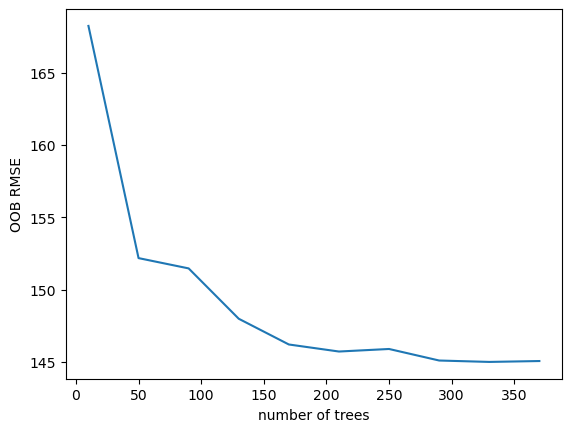

In [51]:
warnings.filterwarnings("ignore")
# find a good n_estimators value
oob_rmse = []

trees = np.arange(10,400,40)

for tree in trees:
    model = RandomForestRegressor(random_state = 1, n_estimators = tree, oob_score=True) # extra input should be there
    model.fit(X_train_cleaned, y_train)
    #find the OOB performance and store it
    oob_rmse.append(mean_squared_error(y_train, model.oob_prediction_, squared=False))

plt.plot(trees, oob_rmse)
plt.ylabel('OOB RMSE')
plt.xlabel('number of trees')

In [52]:
cv = RepeatedKFold(n_splits = 5, random_state = 1)

base_model = DecisionTreeRegressor(random_state = 1)
bag_model = BaggingRegressor(estimator = base_model, n_estimators = 300, random_state = 1)

In [32]:
param_grid = {'max_samples': [0.5, 0.75, 0.9, 1.0],
              'max_features': [0.5, 0.75, 0.9, 1.0],
              'bootstrap_features': [True, False]}
param_list = list(it.product(*[values for key, values in param_grid.items()]))

In [53]:
oob_score_pr = []
for pr in param_list:
    model = BaggingRegressor(max_samples=pr[0], max_features=pr[1],
                            bootstrap_features=pr[2], n_jobs = -1, random_state = 1,
                            oob_score=True, n_estimators = 300).fit(X_train_cleaned, y_train)
    
    oob_score_pr.append(mean_squared_error(model.oob_prediction_, y_train))

**Paste the optimal hyperparameter values below.**

In [54]:
param_list[np.argmin(oob_score_pr)]

(0.75, 0.5, True)

## 3) Model

Using the optimal model hyperparameters, train the model, and paste the code below.

In [55]:
model = BaggingRegressor(max_samples=0.75,max_features=0.5,
                         bootstrap_features=True,n_jobs=-1,random_state=1,oob_score=True,n_estimators=300)

In [56]:
model.fit(X_train_cleaned, y_train)

BaggingRegressor(bootstrap_features=True, max_features=0.5, max_samples=0.75,
                 n_estimators=300, n_jobs=-1, oob_score=True, random_state=1)

In [57]:
pred_bag = model.predict(X_test_cleaned)

## 4) Put any ad-hoc steps for further improving model accuracy
For example, scaling up or scaling down the predictions, capping predictions, etc.

Put code below.

#### Average with Linear Regression Model

In [59]:
y_train_lr = train.log_price

In [60]:
# poly features
poly = PolynomialFeatures(degree = 2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [61]:
# scale the variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [64]:
alphas = np.logspace(-1,3,50)
model2 = RidgeCV(alphas=alphas, cv=5)

model2.fit(X_train_scaled, y_train_lr)

RidgeCV(alphas=array([1.00000000e-01, 1.20679264e-01, 1.45634848e-01, 1.75751062e-01,
       2.12095089e-01, 2.55954792e-01, 3.08884360e-01, 3.72759372e-01,
       4.49843267e-01, 5.42867544e-01, 6.55128557e-01, 7.90604321e-01,
       9.54095476e-01, 1.15139540e+00, 1.38949549e+00, 1.67683294e+00,
       2.02358965e+00, 2.44205309e+00, 2.94705170e+00, 3.55648031e+00,
       4.29193426e+00, 5.17947468e+0...
       9.10298178e+00, 1.09854114e+01, 1.32571137e+01, 1.59985872e+01,
       1.93069773e+01, 2.32995181e+01, 2.81176870e+01, 3.39322177e+01,
       4.09491506e+01, 4.94171336e+01, 5.96362332e+01, 7.19685673e+01,
       8.68511374e+01, 1.04811313e+02, 1.26485522e+02, 1.52641797e+02,
       1.84206997e+02, 2.22299648e+02, 2.68269580e+02, 3.23745754e+02,
       3.90693994e+02, 4.71486636e+02, 5.68986603e+02, 6.86648845e+02,
       8.28642773e+02, 1.00000000e+03]),
        cv=5)

In [65]:
model2.alpha_

323.74575428176433

In [66]:
# preds from bagging/rf --- RMSE on kaggle: 117
pred_bag = model.predict(X_test_cleaned)

In [67]:
# preds from LR
pred_lr = np.exp(model2.predict(X_test_scaled))

In [68]:
# averaged preds--- RMSE on kaggle: 110
average_pred = (pred_bag + pred_lr) / 2

## 5) Export the predictions in the format required to submit on Kaggle
Put code below.

In [70]:
id = test.id.values
predicted = pred_bag
submission = pd.DataFrame({'id': id, 'predicted': predicted})
submission = submission.reset_index(drop=True)
submission.to_csv('bagged_regression_submission.csv', index=False)